# Fama e French Five Factor Model
In questo codice vengono costruiti i 5 fattori di Fama e French, i portafogli LHS, e vengono effettuate le regressioni dei portafogli sui fattori. Per l'ottenimento degli alpha di tutti i portafogli LHS delle Germania, Francia, Italia, Spagna, Finlandia e Olanda si lancia questo codice una volta per ogni nazione con i dataset di rendimenti e caratteristiche del singolo mercato nazionale.
Infine si salvano gli alpha trimestrali dei portafogli.

In [1]:
import pandas as pd
import statsmodels.api as sm
import itertools

## Import dei dati

In [2]:
characteristics_dfs = [] #Lista contenente le caratteristiche delle stock
returns_dfs = [] #Lista contenente i rendimenti delle stock
Rf_dfs = [] #Lista contenente il tasso Euribor
Rm_dfs = [] #Lista contenente il rendimento dell'EUROSTOCK 600

#Per ogni anno vengono caricati i dataframe e aggiunti alle liste.
for i in range(1, 21):
    characteristics_file = f'Caratteristiche_{i}.csv'
    returns_file = f'Rendimenti portafoglio_{i}.csv'
    Rf_file = f'Euribor_{i}.csv'
    Rm_file = f'EUSTOXX600_{i}.csv'

    #Si assegna a tutti i df lo stesso indice
    characteristics_df = pd.read_csv(characteristics_file, sep=';')
    returns_df = pd.read_csv(returns_file, sep=';').set_index('Data')
    Rf_df = pd.read_csv(Rf_file, sep=';').set_index('Data')
    Rm_df = pd.read_csv(Rm_file, sep=';').set_index('Data')

    characteristics_dfs.append(characteristics_df)
    returns_dfs.append(returns_df)
    Rf_dfs.append(Rf_df)
    Rm_dfs.append(Rm_df)


### Pulizia Dataframe
Questa cella controlla che i dataframe annuali di returns_dfs e characteristics_dfs abbiano all'interno i dati relativi agli stessi titoli.
Ogni coppia corrispondente di DataFrame per anno subisce lo stesso processo:

1. Rimozione delle colonne contenenti NaN (.
2. Identificazione delle colonne comuni.
3. Selezione delle colonne comuni in entrambi i DataFrame.
4. Inserimento della colonna Unnamed: 0 nel DataFrame characteristics_final.

I DataFrame puliti e processati per ogni anno vengono poi memorizzati rispettivamente in returns_final_dfs e characteristics_final_dfs.

In [3]:
returns_final_dfs = []
characteristics_final_dfs = []

for i in range(len(returns_dfs)):
    # 1)
    returns_dropped = returns_dfs[i].dropna(axis=1, how='any')
    characteristics_dropped = characteristics_dfs[i].dropna(axis=1, how='any')
    
    # 2)
    common_columns = returns_dropped.columns.intersection(characteristics_dropped.columns)
    
    # 3)
    returns_final = returns_dropped[common_columns]
    characteristics_final = characteristics_dropped[common_columns]
    
    # 4)
    characteristics_final.insert(0, 'Unnamed: 0', characteristics_dfs[i]['Unnamed: 0'])
    
    returns_final_dfs.append(returns_final)
    characteristics_final_dfs.append(characteristics_final)
    
    print(f"Dimensione di 'returns' per anno {i+1} dopo il drop e mantenimento colonne comuni: {returns_final.shape}")
    print(f"Dimensione di 'characteristics' per anno {i+1} dopo il drop e mantenimento colonne comuni: {characteristics_final.shape}")

Dimensione di 'returns' per anno 1 dopo il drop e mantenimento colonne comuni: (262, 600)
Dimensione di 'characteristics' per anno 1 dopo il drop e mantenimento colonne comuni: (4, 601)
Dimensione di 'returns' per anno 2 dopo il drop e mantenimento colonne comuni: (261, 561)
Dimensione di 'characteristics' per anno 2 dopo il drop e mantenimento colonne comuni: (4, 562)
Dimensione di 'returns' per anno 3 dopo il drop e mantenimento colonne comuni: (261, 534)
Dimensione di 'characteristics' per anno 3 dopo il drop e mantenimento colonne comuni: (4, 535)
Dimensione di 'returns' per anno 4 dopo il drop e mantenimento colonne comuni: (260, 530)
Dimensione di 'characteristics' per anno 4 dopo il drop e mantenimento colonne comuni: (4, 531)
Dimensione di 'returns' per anno 5 dopo il drop e mantenimento colonne comuni: (261, 528)
Dimensione di 'characteristics' per anno 5 dopo il drop e mantenimento colonne comuni: (4, 529)
Dimensione di 'returns' per anno 6 dopo il drop e mantenimento colonne

## Costruzione Fattori
In questa sezione si costruiscono i 5 fattori di Fama e French giornalieri.

### Suddivisione per ogni anno delle stock per categoria

In [4]:
all_portafogli_SMB_1 = []
all_portafogli_SMB_2 = []
all_portafogli_SMB_3 = []
all_portafogli_LMH = []
all_portafogli_RMW = []
all_portafogli_CMA = []

combinations_SMB = [(0,0), (0,1), (1,0), (1,1)]
combinations_LMH = [(0,0), (1,0), (0,1), (1,1)]
combinations_RMW = [(0,1), (1,1), (1,0), (0,0)]
combinations_CMA = [(0,0), (1,0), (0,1), (1,1)]

# Funzione che crea i portafogli in base alle combinazioni di caratteristiche.
def crea_portafogli(characteristics_df, combinations, return_df, col_names):
    portafogli = []
    for comb in combinations:
        selected_stocks = characteristics_df[
            (characteristics_df[col_names[0]] == comb[0]) &
            (characteristics_df[col_names[1]] == comb[1])
        ].index.tolist()

        if selected_stocks:  # Verifica che ci siano azioni selezionate.
            portfolio_df = return_df[selected_stocks]
            portfolio_df.name = f"{comb[0]}_{comb[1]}"
            portafogli.append(portfolio_df)
    return portafogli

# Itera su ogni anno nelle liste returns_final_dfs e characteristics_final_dfs.
for year_index in range(len(returns_final_dfs)):
    # Ottieni i DataFrame di returns e characteristics per l'anno corrente.
    returns = returns_final_dfs[year_index]
    characteristics = characteristics_final_dfs[year_index]

    # Trasponi il DataFrame characteristics e imposta la prima riga come intestazione.
    # Manovra necessaria data la forma del dataset.
    characteristics_transposed = characteristics.T
    characteristics_transposed.columns = characteristics_transposed.iloc[0]
    characteristics_transposed = characteristics_transposed[1:]
    
    # Converte le colonne necessarie in interi.
    characteristics_transposed['Size'] = characteristics_transposed['Size'].astype(int)
    characteristics_transposed['Value'] = characteristics_transposed['Value'].astype(int)
    characteristics_transposed['EBIT'] = characteristics_transposed['EBIT'].astype(int)
    characteristics_transposed['INV'] = characteristics_transposed['INV'].astype(int)

    characteristics_SMB_1 = characteristics_transposed.iloc[:, :-2]    #df con Size-Value
    characteristics_SMB_2 = characteristics_transposed.iloc[:, [0, 2]] #df con Size-Ebit
    characteristics_SMB_3 = characteristics_transposed.iloc[:, [0, 3]] #df con Size-INV
    characteristics_LMH = characteristics_transposed.iloc[:, :-2]      #df con Value-Size
    characteristics_RMW = characteristics_transposed.iloc[:, [0, 2]]   #df con Ebit-Size
    characteristics_CMA = characteristics_transposed.iloc[:, [0, 3]]   #df con INV-Size

    #Appende i portafogli costruiti dalla funzione "crea_portafogli" alle liste.
    all_portafogli_SMB_1.append(crea_portafogli(characteristics_SMB_1, combinations_SMB, returns, ['Size', 'Value']))
    all_portafogli_SMB_2.append(crea_portafogli(characteristics_SMB_2, combinations_SMB, returns, ['Size', 'EBIT']))
    all_portafogli_SMB_3.append(crea_portafogli(characteristics_SMB_3, combinations_SMB, returns, ['Size', 'INV']))
    all_portafogli_LMH.append(crea_portafogli(characteristics_LMH, combinations_LMH, returns, ['Size', 'Value']))
    all_portafogli_RMW.append(crea_portafogli(characteristics_RMW, combinations_RMW, returns, ['Size', 'EBIT']))
    all_portafogli_CMA.append(crea_portafogli(characteristics_CMA, combinations_CMA, returns, ['Size', 'INV']))

# Controllo dei numeri di portafogli creati ogni anno (deve essere uno per ogni trimestre)
for year_index in range(len(returns_final_dfs)):
    print(f"\nAnno {year_index + 1}")
    print(f"Numero totale di portafogli SMB_1 creati: {len(all_portafogli_SMB_1[year_index])}")
    print(f"Numero totale di portafogli SMB_2 creati: {len(all_portafogli_SMB_2[year_index])}")
    print(f"Numero totale di portafogli SMB_3 creati: {len(all_portafogli_SMB_3[year_index])}")
    print(f"Numero totale di portafogli LMH creati: {len(all_portafogli_LMH[year_index])}")
    print(f"Numero totale di portafogli RMW creati: {len(all_portafogli_RMW[year_index])}")
    print(f"Numero totale di portafogli CMA creati: {len(all_portafogli_CMA[year_index])}")


Anno 1
Numero totale di portafogli SMB_1 creati: 4
Numero totale di portafogli SMB_2 creati: 4
Numero totale di portafogli SMB_3 creati: 4
Numero totale di portafogli LMH creati: 4
Numero totale di portafogli RMW creati: 4
Numero totale di portafogli CMA creati: 4

Anno 2
Numero totale di portafogli SMB_1 creati: 4
Numero totale di portafogli SMB_2 creati: 4
Numero totale di portafogli SMB_3 creati: 4
Numero totale di portafogli LMH creati: 4
Numero totale di portafogli RMW creati: 4
Numero totale di portafogli CMA creati: 4

Anno 3
Numero totale di portafogli SMB_1 creati: 4
Numero totale di portafogli SMB_2 creati: 4
Numero totale di portafogli SMB_3 creati: 4
Numero totale di portafogli LMH creati: 4
Numero totale di portafogli RMW creati: 4
Numero totale di portafogli CMA creati: 4

Anno 4
Numero totale di portafogli SMB_1 creati: 4
Numero totale di portafogli SMB_2 creati: 4
Numero totale di portafogli SMB_3 creati: 4
Numero totale di portafogli LMH creati: 4
Numero totale di por

### Calcolo rendimento giornaliero di SMB, LHM, RMW e CMA

In [5]:
daily_means_dic_SMB_1 = {}
daily_means_dic_SMB_2 = {}
daily_means_dic_SMB_3 = {}
daily_means_dic_LMH = {}
daily_means_dic_RMW = {}
daily_means_dic_CMA = {}

# Funzione per calcolare le medie giornaliere "daily_means" e memorizzarle nell dizionario
def calculate_daily_means(all_portafogli, daily_means_dic):
    for i, anno in enumerate(all_portafogli, start=1):
        daily_means_list = []
        for portafoglio in anno:
            daily_mean = portafoglio.mean(axis=1)
            daily_means_list.append(daily_mean)
        daily_means_dic[f'anno_{i}'] = daily_means_list

# Calcolo dei daily_means per ciascun portafoglio
calculate_daily_means(all_portafogli_SMB_1, daily_means_dic_SMB_1)
calculate_daily_means(all_portafogli_SMB_2, daily_means_dic_SMB_2)
calculate_daily_means(all_portafogli_SMB_3, daily_means_dic_SMB_3)
calculate_daily_means(all_portafogli_LMH, daily_means_dic_LMH)
calculate_daily_means(all_portafogli_RMW, daily_means_dic_RMW)
calculate_daily_means(all_portafogli_CMA, daily_means_dic_CMA)

Una volta calcolate le medie giornaliere tra tutte le stock di ogni caratteristica, si caclcolano i fattori sottraendo le medie.
Per quanto riguarda SMB bisogna fare la media di SMB_1, SMB_2 e SMB_3.

In [7]:
SMB_1_results = {}
SMB_2_results = {}
SMB_3_results = {}
LMH_results = {}
RMW_results = {}
CMA_results = {}

# Funzione per calcolare i fattori
def calculate_portfolio_results(daily_means_dict, result_dict, portfolio_name):
    for year, daily_means in daily_means_dict.items():
        if len(daily_means) >= 4:
            # Calcola la media dei primi due portafogli (es. Robust_Big e Robust_Small)
            first_portfolio = (daily_means[0] + daily_means[1]) / 2
            # Calcola la media dei secondi due portafogli (es. Weak_Big e Weak_Small)
            second_portfolio = (daily_means[2] + daily_means[3]) / 2
            # Calcola il fattore (es. Robust - Weak)
            result = first_portfolio - second_portfolio
            result_dict[year] = result
        else:
            print(f"Attenzione: meno di 4 portafogli per {year} in {portfolio_name}")

calculate_portfolio_results(daily_means_dic_SMB_1, SMB_1_results, 'SMB_1')
calculate_portfolio_results(daily_means_dic_SMB_2, SMB_2_results, 'SMB_2')
calculate_portfolio_results(daily_means_dic_SMB_3, SMB_3_results, 'SMB_3')
calculate_portfolio_results(daily_means_dic_LMH, LMH_results, 'LMH')
calculate_portfolio_results(daily_means_dic_RMW, RMW_results, 'RMW')
calculate_portfolio_results(daily_means_dic_CMA, CMA_results, 'CMA')

# Calcolo di SMB finale come media dei risultati di SMB_1, SMB_2 e SMB_3
SMB_results = {}

for year in SMB_1_results.keys():
    if year in SMB_2_results and year in SMB_3_results:
        SMB_final = (SMB_1_results[year] + SMB_2_results[year] + SMB_3_results[year]) / 3
        SMB_results[year] = SMB_final
    else:
        print(f"Attenzione: dati non completi per l'anno {year}")

### Calcolo del Fattore di Mercato (Rm-Rf)

In [8]:
RmMrf = []

for anno in range(len(Rm_dfs)):
    Rm = Rm_dfs[anno]
    Rf = Rf_dfs[anno]

    # Sottrai Rf da Rm, mantenendo solo le date presenti in Rm
    Rm_rf = Rm.copy()  # Crea una copia di Rm per preservare l'indice
    Rm_rf['Rm-rf'] = Rm['EUSTOXX600'] - Rf['Euribor']
    Rm_rf.dropna(subset=['Rm-rf'], inplace=True)

    # Appende alla lista solo Rm-Rf
    RmMrf.append(Rm_rf[['Rm-rf']])

for i, df in enumerate(RmMrf):
    print(f"Anno {i+1} Rm-rf DataFrame:\n{df}\n")

Anno 1 Rm-rf DataFrame:
               Rm-rf
Data                
01/07/2003 -0.020130
02/07/2003  0.018163
03/07/2003  0.006256
04/07/2003 -0.002661
07/07/2003  0.023924
...              ...
24/06/2004  0.004025
25/06/2004  0.000042
28/06/2004  0.006338
29/06/2004 -0.004651
30/06/2004 -0.006759

[262 rows x 1 columns]

Anno 2 Rm-rf DataFrame:
               Rm-rf
Data                
01/07/2004 -0.003329
02/07/2004 -0.006930
05/07/2004 -0.000678
06/07/2004 -0.005202
07/07/2004 -0.001512
...              ...
24/06/2005 -0.008235
27/06/2005 -0.009797
28/06/2005  0.008439
29/06/2005  0.002881
30/06/2005 -0.003219

[261 rows x 1 columns]

Anno 3 Rm-rf DataFrame:
               Rm-rf
Data                
01/07/2005  0.007727
04/07/2005  0.002391
05/07/2005 -0.002301
06/07/2005  0.005813
07/07/2005 -0.018305
...              ...
26/06/2006 -0.002892
27/06/2006 -0.006854
28/06/2006  0.001521
29/06/2006  0.017652
30/06/2006  0.013914

[261 rows x 1 columns]

Anno 4 Rm-rf DataFrame:
          

### Organizzazione dei Fattori in un unico Dataframe

In [9]:
fattori_dfs = []

for anno in range(1, 21): 
    fattori_df = pd.DataFrame()
    
    fattori_df['Rm-Rf'] = RmMrf[anno - 1]['Rm-rf'] 
    fattori_df['SMB'] = SMB_results[f'anno_{anno}']
    fattori_df['LMH'] = LMH_results[f'anno_{anno}']
    fattori_df['RMW'] = RMW_results[f'anno_{anno}']
    fattori_df['CMA'] = CMA_results[f'anno_{anno}']
    
    fattori_dfs.append(fattori_df)

Suddivisione dei Dataframes in trimestri

In [10]:
trimestri_dfs = {
    "Q3": [],
    "Q4": [],
    "Q1": [],
    "Q2": []
}

# Suddivisione dei DataFrame in trimestri
for i, fattori_df in enumerate(fattori_dfs):
    fattori_df.index = pd.to_datetime(fattori_df.index, dayfirst=True)
    
    # Filtra i dati in base ai al mese
    X_Q3 = fattori_df.loc[(fattori_df.index.month >= 7) & (fattori_df.index.month <= 9)]   # Luglio - Settembre
    X_Q4 = fattori_df.loc[(fattori_df.index.month >= 10) & (fattori_df.index.month <= 12)]  # Ottobre - Dicembre
    X_Q1 = fattori_df.loc[(fattori_df.index.month >= 1) & (fattori_df.index.month <= 3)]    # Gennaio - Marzo
    X_Q2 = fattori_df.loc[(fattori_df.index.month >= 4) & (fattori_df.index.month <= 6)]    # Aprile - Giugno

    trimestri_dfs["Q3"].append(X_Q3)
    trimestri_dfs["Q4"].append(X_Q4)
    trimestri_dfs["Q1"].append(X_Q1)
    trimestri_dfs["Q2"].append(X_Q2)


In [11]:
for anno in range(1, 21): 
    print(f"\nAnno {anno}:\n")
    print("\nQ3 (Luglio-Settembre):")
    print(trimestri_dfs["Q3"][anno - 1].head())
    print("\nQ4 (Ottobre-Dicembre):")
    print(trimestri_dfs["Q4"][anno - 1].head())
    print("Q1 (Gennaio-Marzo):")
    print(trimestri_dfs["Q1"][anno - 1].head())
    print("\nQ2 (Aprile-Giugno):")
    print(trimestri_dfs["Q2"][anno - 1].head())


Anno 1:


Q3 (Luglio-Settembre):
               Rm-Rf       SMB       LMH       RMW       CMA
Data                                                        
2003-07-01 -0.020130 -0.004076  0.003639  0.002207 -0.005582
2003-07-02  0.018163 -0.001943 -0.005087 -0.005084  0.002190
2003-07-03  0.006256  0.001086  0.005266  0.000574  0.005659
2003-07-04 -0.002661  0.007053 -0.004632 -0.000188  0.003441
2003-07-07  0.023924 -0.001905 -0.001739 -0.003882  0.006863

Q4 (Ottobre-Dicembre):
               Rm-Rf       SMB       LMH       RMW       CMA
Data                                                        
2003-10-01  0.013965 -0.007705 -0.005940  0.003984  0.001589
2003-10-02  0.005394  0.009901 -0.005076 -0.003327  0.002697
2003-10-03  0.024681 -0.008859 -0.000917 -0.004086  0.003847
2003-10-06 -0.005321 -0.003623  0.001650  0.008428 -0.007479
2003-10-07 -0.008455  0.000243  0.004794 -0.002474  0.001427
Q1 (Gennaio-Marzo):
               Rm-Rf       SMB       LMH       RMW       CMA
Data   

## Costruzione Portafogli LHS
Si caricano i dataframe con le caratteristiche delle stock suddivise per terzili

In [12]:
LHS_characteristics_dfs = []

for i in range(1, 21):
    # Crea i nomi dei file con suffissi
    LHS_chara_file = f'LHS_{i}.csv'
    LHS_characteristics_df = pd.read_csv(LHS_chara_file, sep=';')

    LHS_characteristics_dfs.append(LHS_characteristics_df)

In [13]:
# Si ripuliscono i dataframe appena caricati sulla base di "characteristics_final_dfs"
for i in range(len(LHS_characteristics_dfs)):
    characteristics_df = characteristics_final_dfs[i]
    lhs_df = LHS_characteristics_dfs[i]

    columns_to_keep = characteristics_df.columns
    # Filtra il DataFrame di LHS per mantenere solo le colonne presenti in characteristics_df
    LHS_characteristics_dfs[i] = lhs_df[columns_to_keep]


### Creazione Portafogli

In [14]:
all_portafogli_SizeBM = []
all_portafogli_SizeEbit = []
all_portafogli_SizeINV = []

# Si definiscono le combinazioni per ogni categoria
combinations_SizeBM = [(0, 0), (0, 1), (0, 2),
                       (1, 0), (1, 1), (1, 2),
                       (2, 0), (2, 1), (2, 2)]
combinations_SizeEbit = [(0, 0), (0, 1), (0, 2),
                         (1, 0), (1, 1), (1, 2),
                         (2, 0), (2, 1), (2, 2)]
combinations_SizeINV = [(0, 0), (0, 1), (0, 2),
                        (1, 0), (1, 1), (1, 2),
                        (2, 0), (2, 1), (2, 2)]

# Funzione per creare i portafogli per un insieme di combinazioni e caratteristiche specifiche
def crea_portafogli(characteristics_df, combinations, return_df, col_names, anno, tipo_portafoglio):
    portafogli = []
    for comb in combinations:
        selected_stocks = characteristics_df[
            (characteristics_df[col_names[0]] == comb[0]) &
            (characteristics_df[col_names[1]] == comb[1])
        ].index.tolist()

        if not selected_stocks:  # Se non ci sono azioni selezionate
            print(f"Anno: {anno},  Tipo Portafoglio: {tipo_portafoglio}, Combinazione: {comb} - Nessuna azione trovata")
            missing_counts[tipo_portafoglio][comb] += 1

            # Prendi un indice di una stock qualsiasi dal trimestre corrente
            if not return_df.empty:  # Assicurati che il DataFrame non sia vuoto
                random_stock_index = return_df.columns[0]  # Prendi la prima stock come esempio
                portfolio_df = pd.DataFrame(0, index=returns.index, columns=[random_stock_index])  # Tutti i valori a zero
                portfolio_df.name = f"{tipo_portafoglio}_{comb[0]}_{comb[1]}"
                portafogli.append(portfolio_df)
        else:  # Se ci sono azioni selezionate
            portfolio_df = return_df[selected_stocks]
            portfolio_df.name = f"{tipo_portafoglio}_{comb[0]}_{comb[1]}"
            portafogli.append(portfolio_df)
                
    return portafogli

data = []

# Contatore delle mancanze di corrispondenze per ogni portafoglio
missing_counts = {
    "Size/BM": {comb: 0 for comb in combinations_SizeBM},
    "Size/EBIT": {comb: 0 for comb in combinations_SizeEbit},
    "Size/INV": {comb: 0 for comb in combinations_SizeINV}
}

total_years = 20  

for year_index in range(len(returns_final_dfs)):
    returns = returns_final_dfs[year_index]
    characteristics = LHS_characteristics_dfs[year_index]
    
    anno = f"Anno {year_index + 1}"

    # Traspone il DataFrame characteristics e imposta la prima riga come intestazione.
    characteristics_transposed = characteristics.T
    characteristics_transposed.columns = characteristics_transposed.iloc[0]
    characteristics_transposed = characteristics_transposed[1:]

    characteristics_transposed['Size'] = characteristics_transposed['Size'].astype(int)
    characteristics_transposed['Value'] = characteristics_transposed['Value'].astype(int)
    characteristics_transposed['EBIT'] = characteristics_transposed['EBIT'].astype(int)
    characteristics_transposed['INV'] = characteristics_transposed['INV'].astype(int)

    characteristics_SizeBM = characteristics_transposed.iloc[:, :-2]
    characteristics_SizeEbit = characteristics_transposed.iloc[:, [0, 2]]
    characteristics_SizeINV = characteristics_transposed.iloc[:, [0, 3]]

    # Creazione dei portafogli per ogni categoria e aggiunta ai rispettivi elenchi
    all_portafogli_SizeBM.append(crea_portafogli(characteristics_SizeBM, combinations_SizeBM, returns, ['Size', 'Value'], anno, "Size/BM"))
    all_portafogli_SizeEbit.append(crea_portafogli(characteristics_SizeEbit, combinations_SizeEbit, returns, ['Size', 'EBIT'], anno, "Size/EBIT"))
    all_portafogli_SizeINV.append(crea_portafogli(characteristics_SizeINV, combinations_SizeINV, returns, ['Size', 'INV'], anno, "Size/INV"))


Anno: Anno 7,  Tipo Portafoglio: Size/EBIT, Combinazione: (0, 2) - Nessuna azione trovata
Anno: Anno 10,  Tipo Portafoglio: Size/EBIT, Combinazione: (0, 2) - Nessuna azione trovata
Anno: Anno 11,  Tipo Portafoglio: Size/EBIT, Combinazione: (0, 2) - Nessuna azione trovata
Anno: Anno 14,  Tipo Portafoglio: Size/EBIT, Combinazione: (0, 2) - Nessuna azione trovata
Anno: Anno 15,  Tipo Portafoglio: Size/EBIT, Combinazione: (0, 2) - Nessuna azione trovata
Anno: Anno 16,  Tipo Portafoglio: Size/EBIT, Combinazione: (0, 2) - Nessuna azione trovata
Anno: Anno 20,  Tipo Portafoglio: Size/EBIT, Combinazione: (0, 2) - Nessuna azione trovata


### Calcolo di statistiche sulla composizione dei portafogli

In [16]:
# Calcola il numero di azioni in ogni portafoglio e memorizza i risultati
for year_index in range(len(all_portafogli_SizeBM)):
    year = f"Anno {year_index + 1}"
    
    for portfolio in all_portafogli_SizeBM[year_index]:
        num_stocks = len(portfolio.columns)  
        data.append({"Anno": year, "Tipo Portafoglio": "Size/BM", "Nome Portafoglio": portfolio.name, "Numero Azioni": num_stocks})

    for portfolio in all_portafogli_SizeEbit[year_index]:
        num_stocks = len(portfolio.columns)
        data.append({"Anno": year, "Tipo Portafoglio": "Size/EBIT", "Nome Portafoglio": portfolio.name, "Numero Azioni": num_stocks})

    for portfolio in all_portafogli_SizeINV[year_index]:
        num_stocks = len(portfolio.columns)
        data.append({"Anno": year, "Tipo Portafoglio": "Size/INV", "Nome Portafoglio": portfolio.name, "Numero Azioni": num_stocks})

# Calcola la percentuale di trimestri in cui sono presenti stock selezionate
for tipo_portafoglio, combinations in missing_counts.items():
    for comb, count in combinations.items():
        present_years = total_years - count 
        percentuale = (present_years / total_years) * 100  

        data.append({"Anno": "Totale", "Tipo Portafoglio": tipo_portafoglio, "Combinazione": comb, "Percentuale Anni con Stock": percentuale})

# Crea un DataFrame con i risultati
portafogli_df = pd.DataFrame(data)

output_file = 'portafogli_azioni_percentuale_trimestri.xlsx'
portafogli_df.to_excel(output_file, index=False)

print(f"File Excel creato: {output_file}")



File Excel creato: portafogli_azioni_percentuale_trimestri.xlsx


In [17]:
# Funzione per calcolare le medie giornaliere e popolare il dizionario
def calculate_daily_means(all_portafogli, daily_means_dic):
    for i, anno in enumerate(all_portafogli, start=1):
        daily_means_list = [portafoglio.mean(axis=1) for portafoglio in anno]
        daily_means_dic[f'anno_{i}'] = daily_means_list

daily_means_dic_SizeBM = {}
daily_means_dic_SizeEbit = {}
daily_means_dic_SizeINV = {}

calculate_daily_means(all_portafogli_SizeBM, daily_means_dic_SizeBM)
calculate_daily_means(all_portafogli_SizeEbit, daily_means_dic_SizeEbit)
calculate_daily_means(all_portafogli_SizeINV, daily_means_dic_SizeINV)


In [18]:
# Funzione per calcolare i risultati della sottrazione (Rm-Rf)
def calculate_RMRf(daily_means_dic, Rf_dfs):
    RMRf_dic = {}
    for key, df_list in daily_means_dic.items():
        adjusted_df_list = []

        # Estrai l'indice dall'intestazione della chiave (es: 'anno_1' -> 0)
        year_index = int(key.split('_')[1]) - 1  

        # Ottieni il DataFrame corrispondente in Rf_dfs
        rf_df = Rf_dfs[year_index]  

        for df in df_list:
            rf_aligned = rf_df['Euribor'].reindex(df.index)  # Allinea rf_df['Euribor'] agli indici di df
            adjusted_df = df - rf_aligned  # Sottrai i valori allineati
            adjusted_df_list.append(adjusted_df)

        RMRf_dic[key] = adjusted_df_list

    return RMRf_dic

# Calcolo dei risultati RMRf per ogni gruppo di portafogli
RMRf_SizeBM = calculate_RMRf(daily_means_dic_SizeBM, Rf_dfs)
RMRf_SizeEbit = calculate_RMRf(daily_means_dic_SizeEbit, Rf_dfs)
RMRf_SizeINV = calculate_RMRf(daily_means_dic_SizeINV, Rf_dfs)


Suddivisione dei portafogli in trimestri

In [19]:
y_SizeBM = {f"anno_{i}": {"Q1": [], "Q2": [], "Q3": [], "Q4": []} for i in range(1, 21)}
y_SizeEbit = {f"anno_{i}": {"Q1": [], "Q2": [], "Q3": [], "Q4": []} for i in range(1, 21)}
y_SizeINV = {f"anno_{i}": {"Q1": [], "Q2": [], "Q3": [], "Q4": []} for i in range(1, 21)}

# Funzione per suddividere i DataFrame in trimestri
def suddividi_in_trimestri(daily_means_dic, output_dic):
    for year_index, (key, df_list) in enumerate(daily_means_dic.items()):
        for portfolio_df in df_list:
            portfolio_df.index = pd.to_datetime(portfolio_df.index, dayfirst=True)

            # Dividi i dati in trimestri sulla base dei mesi
            X_Q3 = portfolio_df.loc[(portfolio_df.index.month >= 7) & (portfolio_df.index.month <= 9)]   # Luglio - Settembre
            X_Q4 = portfolio_df.loc[(portfolio_df.index.month >= 10) & (portfolio_df.index.month <= 12)]  # Ottobre - Dicembre
            X_Q1 = portfolio_df.loc[(portfolio_df.index.month >= 1) & (portfolio_df.index.month <= 3)]    # Gennaio - Marzo
            X_Q2 = portfolio_df.loc[(portfolio_df.index.month >= 4) & (portfolio_df.index.month <= 6)]    # Aprile - Giugno

            output_dic[key]["Q3"].append(X_Q3)
            output_dic[key]["Q4"].append(X_Q4)
            output_dic[key]["Q1"].append(X_Q1)
            output_dic[key]["Q2"].append(X_Q2)

suddividi_in_trimestri(daily_means_dic_SizeBM, y_SizeBM)
suddividi_in_trimestri(daily_means_dic_SizeEbit, y_SizeEbit)
suddividi_in_trimestri(daily_means_dic_SizeINV, y_SizeINV)


## Regressioni di FF5

In [20]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# Funzione per calcolare e salvare le statistiche delle regressioni 
def salva_statistiche_regressione(y_data, x_data, label, risultati, conteggi):
    for anno, trimestri in y_data.items():
        for trimestre in ["Q3", "Q4", "Q1", "Q2"]:
            for i, y in enumerate(trimestri[trimestre]):
                if not x_data[trimestre][int(anno.split("_")[1]) - 1].empty and not y.empty:
                    X = x_data[trimestre][int(anno.split("_")[1]) - 1]
                    X = sm.add_constant(X)  
                    y_aligned, X_aligned = y.align(X, join='inner', axis=0)

                    portafoglio_key = f"Portafoglio_{i + 1}"

                    #Dizionario per raccolta delle statistiche.
                    if portafoglio_key not in conteggi:
                        conteggi[portafoglio_key] = {
                            "OLS": 0,
                            "RLM": 0,
                            "Residui Non Normali": 0,
                            "Eteroschedasticità": 0,
                            "OLS con HC3": 0,  
                            "Regressioni Totali": 0,  
                        }
                    # conteggio delle regressioni totali
                    conteggi[portafoglio_key]["Regressioni Totali"] += 1

                    # Esegui il modello OLS per poi effettuare White test e Jarque Bera test seui residui
                    modello = sm.OLS(y_aligned, X_aligned).fit()
                    jb_test = jarque_bera(modello.resid)
                    white_test = het_white(modello.resid, modello.model.exog)

                    # Flag per scegliere RLM se i residui non sono normali
                    utilizzo_rlm = jb_test[1] < 0.05  
                    
                    # Se c'è eteroschedasticità utilizza la matric di covarianza HC3.
                    if white_test[1] < 0.05:
                        modello_robusto = sm.OLS(y_aligned, X_aligned).fit(cov_type='HC3')
                        alpha = modello_robusto.params.get('const', None)
                        pvalues_alpha = modello_robusto.pvalues.get('const', None)
                        r_squared = modello_robusto.rsquared
                        conteggi[portafoglio_key]["Eteroschedasticità"] += 1
                        conteggi[portafoglio_key]["OLS con HC3"] += 1  # Incrementa OLS con HC3
                        coeff_regressori = modello_robusto.params.drop('const') if 'const' in modello_robusto.params else modello_robusto.params
                        pvalues = modello_robusto.pvalues

                    # Se non c'è eteroschedasticità e i residui sono normali utilizza il modello OLS.
                    elif not utilizzo_rlm:
                        alpha = modello.params.get('const', None)
                        pvalues_alpha = modello.pvalues.get('const', None)
                        r_squared = modello.rsquared
                        conteggi[portafoglio_key]["OLS"] += 1  # Incrementa OLS
                        coeff_regressori = modello.params.drop('const') if 'const' in modello.params else modello.params
                        pvalues = modello.pvalues

                    # Se ci sono residui non normali, esegui RLM
                    elif utilizzo_rlm:
                        modello_rlm = sm.RLM(y_aligned, X_aligned).fit()
                        alpha = modello_rlm.params.get('const', None)
                        pvalues_alpha = modello_rlm.pvalues.get('const', None)  # Non c'è p-value per RLM
                        r_squared_adj = None  # Imposta a None per i modelli RLM
                        if sum((y_aligned - y_aligned.mean()) ** 2) == 0:
                            pseudo_r_squared = None  
                        else:
                            pseudo_r_squared = 1 - (sum(modello_rlm.resid ** 2) / sum((y_aligned - y_aligned.mean()) ** 2))
                        conteggi[portafoglio_key]["Residui Non Normali"] += 1  # Incrementa residui non normali
                        conteggi[portafoglio_key]["RLM"] += 1  # Incrementa RLM
                        coeff_regressori = modello_rlm.params.drop('const') if 'const' in modello_rlm.params else modello_rlm.params
                        pvalues = modello_rlm.pvalues  # Non c'è p-value per RLM

                    # Test di Durbin-Watson sui residui.
                    durbin_watson_test = durbin_watson(modello.resid)

                    risultati.append({
                        "Anno": anno,
                        "Trimestre": trimestre,
                        "Portafoglio": portafoglio_key,
                        "Alpha": alpha,
                        "P-value Alpha": pvalues_alpha,
                        "R²": r_squared,
                        "Pseudo R²": pseudo_r_squared if utilizzo_rlm else None,
                        "Jarque-Bera P-value": jb_test[1],
                        "White P-value": white_test[1],
                        "Durbin-Watson": durbin_watson_test,
                        "Tipo di Modello": "RLM" if utilizzo_rlm else "OLS"
                    })

                    # Aggiungi i coefficienti dei regressori e i p-value
                    if coeff_regressori is not None:
                        for nome_regressore, coeff in coeff_regressori.items():
                            risultati[-1][f"Coeff {nome_regressore}"] = coeff
                            risultati[-1][f"P-value {nome_regressore}"] = pvalues[nome_regressore] if pvalues is not None else None

    return risultati, conteggi

# Funzione principale aggiornata per calcolare percentuali OLS con cov_type=HC3
def esegui_regressioni(y_data_list, x_data_list, labels, filename):
    risultati = []
    
    with pd.ExcelWriter(filename) as writer:
        for y_data, x_data, label in zip(y_data_list, x_data_list, labels):
            conteggi = {} 
            #Esegue funzione salva_statistiche_regressione:
            # "risultati" contiene coefficienti e p-values, "conteggi" contiene i numeri di regressioni.
            risultati, conteggi = salva_statistiche_regressione(y_data, x_data, label, risultati, conteggi)

            # Calcola percentuali di utilizzo.
            percentuali = []
            for portafoglio, stats in conteggi.items():
                totale = stats["Regressioni Totali"]
                percentuali.append({
                    "Portafoglio": portafoglio,
                    "Percentuale OLS": (stats["OLS"] / totale) * 100 if totale > 0 else 0,
                    "Percentuale RLM": (stats["RLM"] / totale) * 100 if totale > 0 else 0,
                    "Percentuale OLS con HC3": (stats["OLS con HC3"] / totale) * 100 if totale > 0 else 0,
                    "Percentuale Residui Non Normali": (stats["Residui Non Normali"] / totale) * 100 if totale > 0 else 0,
                    "Percentuale Eteroschedasticità": (stats["Eteroschedasticità"] / totale) * 100 if totale > 0 else 0,
                    "Numero Residui Non Normali": stats["Residui Non Normali"],  
                    "Regressioni Totali": stats["Regressioni Totali"]  
                })

            percentuali_df = pd.DataFrame(percentuali)

            # Download di file excel per risultati e statistiche.
            risultati_df = pd.DataFrame(risultati)
            risultati_df.to_excel(writer, sheet_name=f'Risultati_{label}', index=False)
            percentuali_df.to_excel(writer, sheet_name=f'Percentuali_{label}', index=False)

            for portafoglio, stats in conteggi.items():
                totale = stats["Regressioni Totali"]
                percentuale_residui_non_normali = (stats["Residui Non Normali"] / totale) * 100 if totale > 0 else 0
                percentuale_ols_hc3 = (stats["OLS con HC3"] / totale) * 100 if totale > 0 else 0
                print(f"{portafoglio}: {stats['Residui Non Normali']} residui non normali, "
                      f"{percentuale_residui_non_normali:.2f}% dei casi, {percentuale_ols_hc3:.2f}% OLS con HC3, "
                      f"{stats['Regressioni Totali']} regressioni totali")

# Esegui la funzione per ogni gruppo di portafogli.
esegui_regressioni([y_SizeBM, y_SizeEbit, y_SizeINV], [trimestri_dfs, trimestri_dfs, trimestri_dfs], ["SizeBM", "SizeEbit", "SizeINV"], "statistiche_completato.xlsx")


Portafoglio_1: 5 residui non normali, 6.25% dei casi, 30.00% OLS con HC3, 80 regressioni totali
Portafoglio_2: 7 residui non normali, 8.75% dei casi, 22.50% OLS con HC3, 80 regressioni totali
Portafoglio_3: 7 residui non normali, 8.75% dei casi, 20.00% OLS con HC3, 80 regressioni totali
Portafoglio_4: 10 residui non normali, 12.50% dei casi, 25.00% OLS con HC3, 80 regressioni totali
Portafoglio_5: 11 residui non normali, 13.75% dei casi, 25.00% OLS con HC3, 80 regressioni totali
Portafoglio_6: 13 residui non normali, 16.25% dei casi, 15.00% OLS con HC3, 80 regressioni totali
Portafoglio_7: 13 residui non normali, 16.25% dei casi, 18.75% OLS con HC3, 80 regressioni totali
Portafoglio_8: 11 residui non normali, 13.75% dei casi, 30.00% OLS con HC3, 80 regressioni totali
Portafoglio_9: 9 residui non normali, 11.25% dei casi, 21.25% OLS con HC3, 80 regressioni totali


C:\Users\micha\miniconda3\envs\luglio\lib\site-packages\statsmodels\regression\linear_model.py:1871: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\micha\miniconda3\envs\luglio\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\micha\miniconda3\envs\luglio\lib\site-packages\statsmodels\robust\robust_linear_model.py:166: RuntimeWarning: invalid value encountered in true_divide
  return self.M(tmp_resid / tmp_results.scale).sum()
C:\Users\micha\miniconda3\envs\luglio\lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
C:\Users\micha\miniconda3\envs\luglio\lib\site-packages\statsmodels\stats\stattools.py:50

Portafoglio_1: 4 residui non normali, 5.00% dei casi, 31.25% OLS con HC3, 80 regressioni totali
Portafoglio_2: 9 residui non normali, 11.25% dei casi, 32.50% OLS con HC3, 80 regressioni totali
Portafoglio_3: 52 residui non normali, 65.00% dei casi, 11.25% OLS con HC3, 80 regressioni totali
Portafoglio_4: 13 residui non normali, 16.25% dei casi, 33.75% OLS con HC3, 80 regressioni totali
Portafoglio_5: 8 residui non normali, 10.00% dei casi, 20.00% OLS con HC3, 80 regressioni totali
Portafoglio_6: 12 residui non normali, 15.00% dei casi, 22.50% OLS con HC3, 80 regressioni totali
Portafoglio_7: 13 residui non normali, 16.25% dei casi, 23.75% OLS con HC3, 80 regressioni totali
Portafoglio_8: 14 residui non normali, 17.50% dei casi, 21.25% OLS con HC3, 80 regressioni totali
Portafoglio_9: 8 residui non normali, 10.00% dei casi, 33.75% OLS con HC3, 80 regressioni totali
Portafoglio_1: 7 residui non normali, 8.75% dei casi, 35.00% OLS con HC3, 80 regressioni totali
Portafoglio_2: 11 residui n

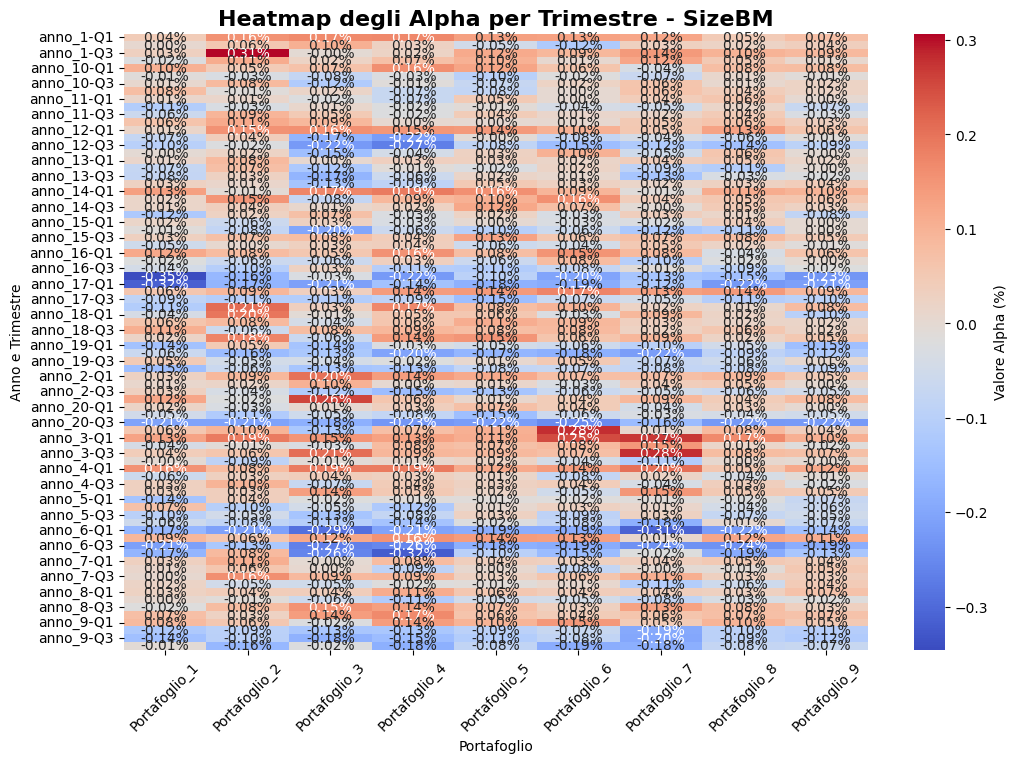

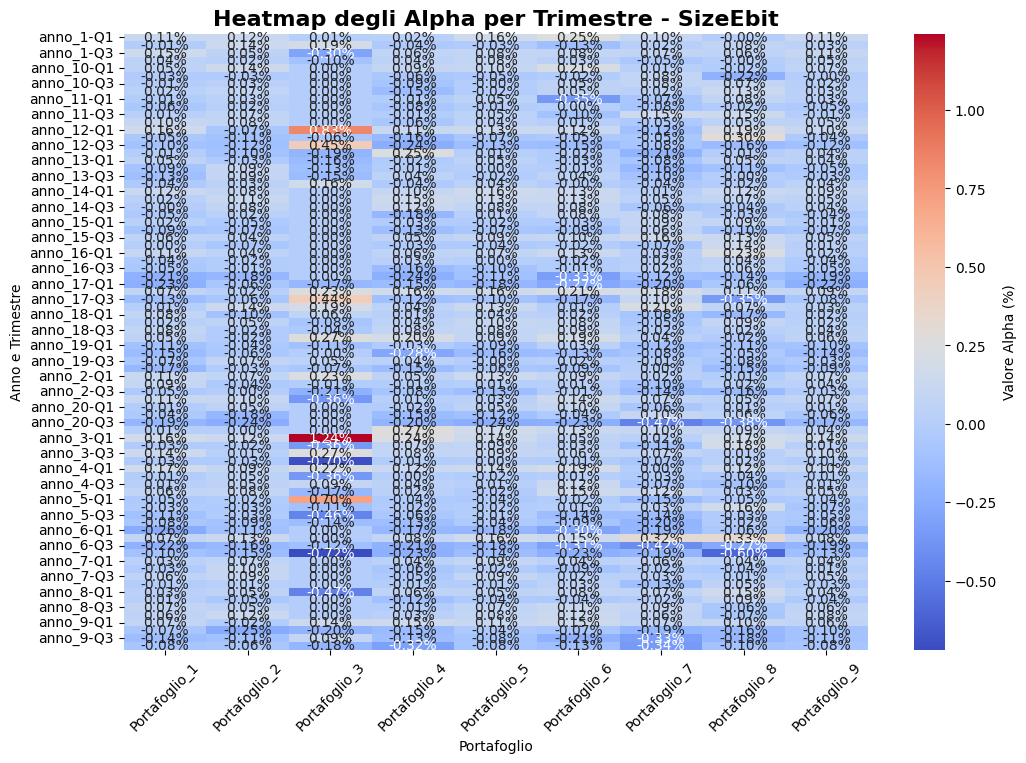

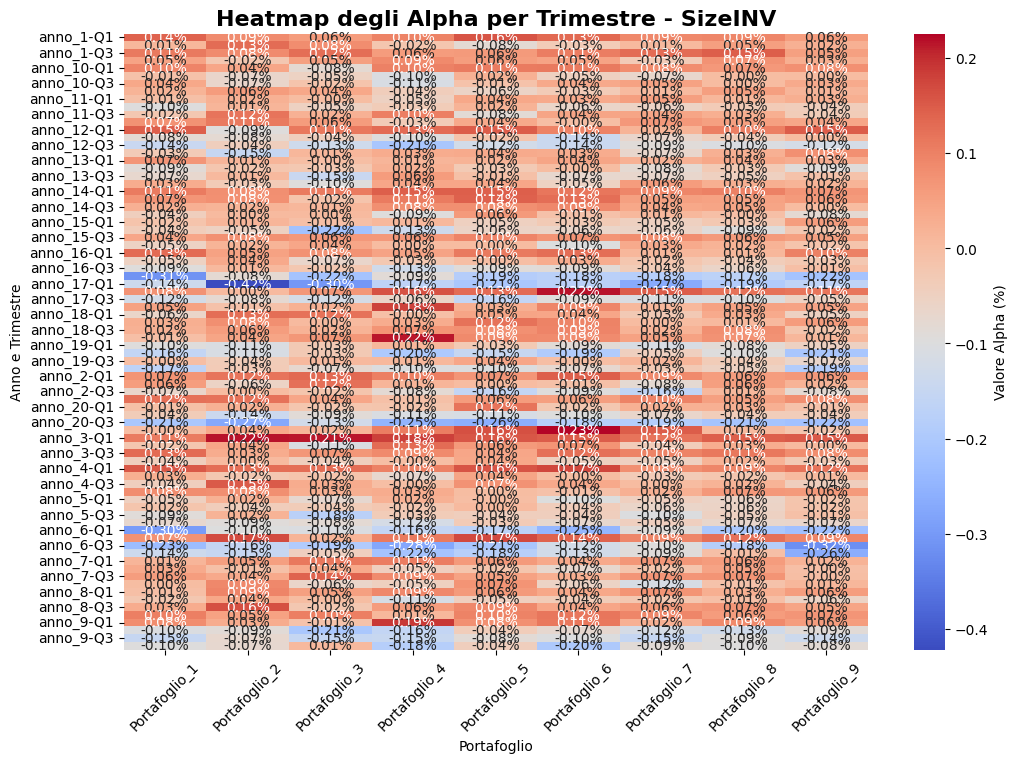

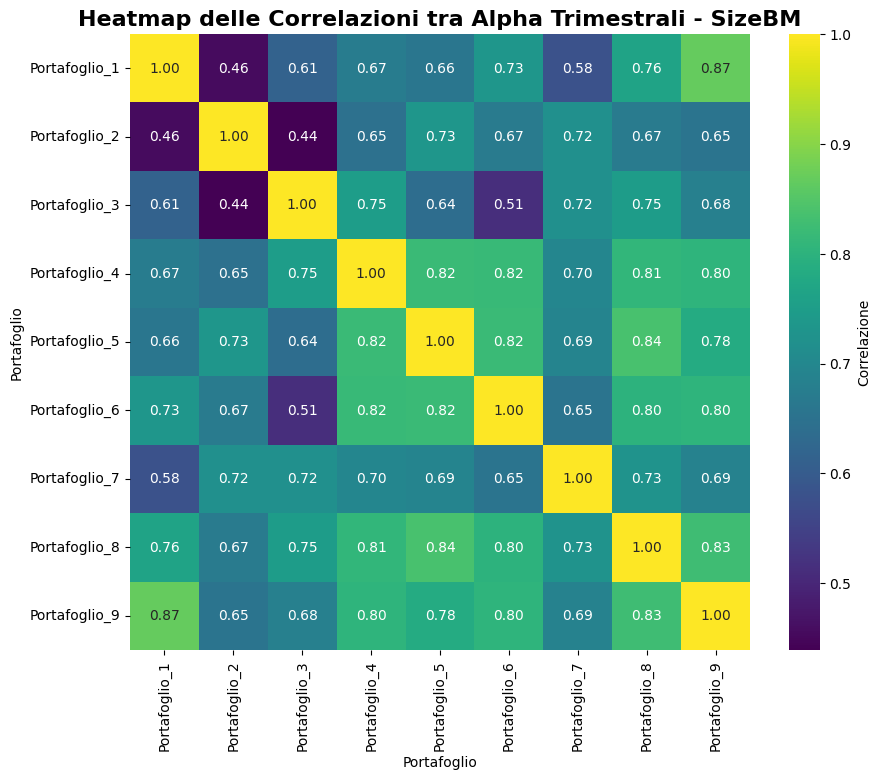

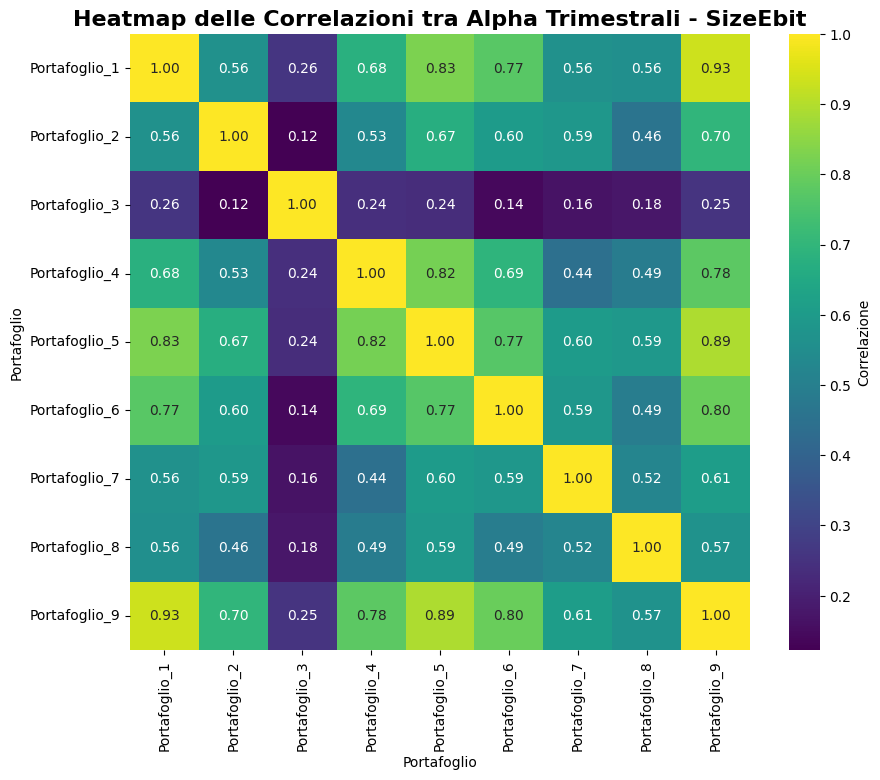

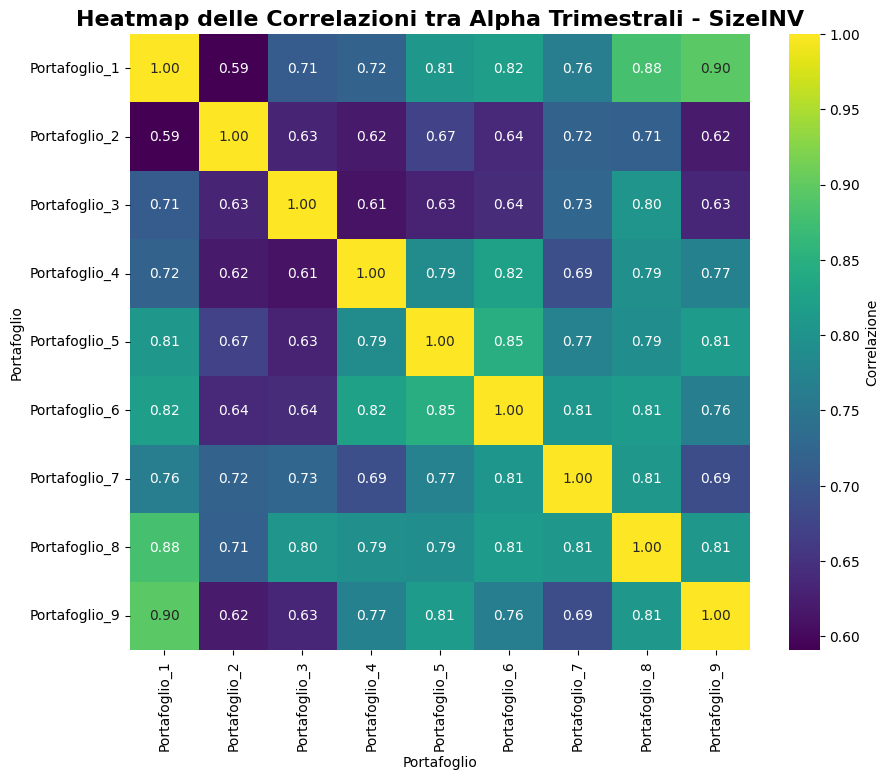

In [23]:
# Carica i risultati dai file Excel
risultati_SizeBM = pd.read_excel("statistiche_SizeBM.xlsx")
risultati_SizeEbit = pd.read_excel("statistiche_SizeEbit.xlsx")
risultati_SizeINV = pd.read_excel("statistiche_SizeINV.xlsx")

# Funzione per creare una heatmap degli alpha per trimestre e portafoglio
def heatmap_alpha_trimestrale(risultati_df, titolo="Heatmap degli Alpha per Trimestre"):
    # Crea una tabella pivot per i valori di alpha con portafoglio e trimestre
    alpha_trimestrali = risultati_df.pivot_table(values="Alpha", index=["Anno", "Trimestre"], columns="Portafoglio")

    # Crea la heatmap degli alpha trimestrali
    plt.figure(figsize=(12, 8))
    
    # Imposta il formato come percentuale con due decimali
    sns.heatmap(alpha_trimestrali * 100, 
                annot=alpha_trimestrali.applymap(lambda x: f"{x * 100:.2f}%" if pd.notnull(x) else ""), 
                fmt="", 
                cmap="coolwarm", 
                cbar_kws={'label': 'Valore Alpha (%)'})

    # Titolo e visualizzazione della heatmap
    plt.title(titolo, fontsize=16, fontweight="bold")
    plt.xlabel("Portafoglio")
    plt.ylabel("Anno e Trimestre")
    plt.xticks(rotation=45)  # Ruota le etichette delle colonne per leggibilità
    plt.show()

    return alpha_trimestrali  # Ritorna la tabella degli alpha trimestrali per uso successivo

# Funzione per calcolare e visualizzare la correlazione tra gli alpha trimestrali
def heatmap_correlation_alpha(alpha_trimestrali_df, titolo="Heatmap delle Correlazioni tra Alpha Trimestrali"):
    # Calcola la matrice di correlazione
    corr_matrix = alpha_trimestrali_df.corr()

    # Crea la heatmap delle correlazioni
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Correlazione'})

    # Titolo e visualizzazione della heatmap
    plt.title(titolo, fontsize=16, fontweight="bold")
    plt.xlabel("Portafoglio")
    plt.ylabel("Portafoglio")
    plt.show()

# Visualizza la heatmap degli alpha trimestrali per ciascun file di risultati
alpha_trimestrali_SizeBM = heatmap_alpha_trimestrale(risultati_SizeBM, titolo="Heatmap degli Alpha per Trimestre - SizeBM")
alpha_trimestrali_SizeEbit = heatmap_alpha_trimestrale(risultati_SizeEbit, titolo="Heatmap degli Alpha per Trimestre - SizeEbit")
alpha_trimestrali_SizeINV = heatmap_alpha_trimestrale(risultati_SizeINV, titolo="Heatmap degli Alpha per Trimestre - SizeINV")

# Visualizza le correlazioni tra gli alpha trimestrali per ciascun set di risultati
heatmap_correlation_alpha(alpha_trimestrali_SizeBM, titolo="Heatmap delle Correlazioni tra Alpha Trimestrali - SizeBM")
heatmap_correlation_alpha(alpha_trimestrali_SizeEbit, titolo="Heatmap delle Correlazioni tra Alpha Trimestrali - SizeEbit")
heatmap_correlation_alpha(alpha_trimestrali_SizeINV, titolo="Heatmap delle Correlazioni tra Alpha Trimestrali - SizeINV")
